# Embeddable Funnel Analysis Report
## Executive Summary Dashboard

This report provides a comprehensive analysis of submission performance across our three primary funnels:
- **Medication V1**: Primary medication funnel
- **Tirzepatide V1**: Tirzepatide-specific funnel  
- **Semaglutide V1**: Semaglutide-specific funnel

**Data Source**: CSV files from `Embeddables/Data/` directory

---

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
import warnings
warnings.filterwarnings('ignore')

# Set style for professional appearance
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [27]:
# Load all CSV data from Embeddables/Data/
print("Loading embeddable CSV data...")

# Define our funnels and data structure
FUNNELS = {
    'medication_v1': 'Medication V1',
    'tirzepatide_v1': 'Tirzepatide V1', 
    'semaglutide_v1': 'Semaglutide V1'
}

# Load all data files
funnel_data = {}

for funnel_key, funnel_name in FUNNELS.items():
    # Find files for this funnel
    all_file = glob.glob(f'Embeddables/Data/{funnel_key}_*_all.csv')[0]
    complete_file = glob.glob(f'Embeddables/Data/{funnel_key}_*_complete.csv')[0]
    partial_file = glob.glob(f'Embeddables/Data/{funnel_key}_*_partial.csv')[0]
    
    funnel_data[funnel_key] = {
        'all': pd.read_csv(all_file),
        'complete': pd.read_csv(complete_file),
        'partial': pd.read_csv(partial_file),
        'name': funnel_name
    }
    
    print(f"✅ {funnel_name}:")
    print(f"   - Total: {len(funnel_data[funnel_key]['all']):,} entries")
    print(f"   - Complete: {len(funnel_data[funnel_key]['complete']):,} entries")
    print(f"   - Partial: {len(funnel_data[funnel_key]['partial']):,} entries")

# Load checkout sessions data from GoogleSheets
print(f"\n🛒 Loading checkout sessions data...")
checkout_sessions_df = pd.read_excel('GoogleSheets/Embeddables.xlsx', sheet_name='checkout.sessions')
print(f"✅ Checkout sessions: {len(checkout_sessions_df):,} total sessions")

# Show cart distribution
print("   Cart distribution:")
if 'Cart Launched' in checkout_sessions_df.columns:
    cart_counts = checkout_sessions_df['Cart Launched'].value_counts()
    for cart, count in cart_counts.items():
        print(f"     - {cart}: {count}")

print(f"\n📊 Analysis covers {len(FUNNELS)} funnels loaded successfully!")

Loading embeddable CSV data...
✅ Medication V1:
   - Total: 276 entries
   - Complete: 113 entries
   - Partial: 163 entries
✅ Tirzepatide V1:
   - Total: 175 entries
   - Complete: 92 entries
   - Partial: 83 entries
✅ Semaglutide V1:
   - Total: 88 entries
   - Complete: 48 entries
   - Partial: 40 entries

🛒 Loading checkout sessions data...
✅ Checkout sessions: 531 total sessions
   Cart distribution:
     - Tirzepatide_90day: 10
     - Tirzepatide_monthly: 6
     - Semaglutide_90day: 6
     - Semaglutide_monthly: 4
     - Semaglutide_b2g1: 2
     - Semaglutide_lifetime: 1
     - Semaglutide_oral: 1
     - Tirzepatide_b2g1: 1

📊 Analysis covers 3 funnels loaded successfully!


## 📊 Main Performance Summary Table

### Key Definitions:
- **Initiated Submissions**: All entries that started the funnel process (from `_all.csv`)
- **Completed Submissions**: Entries that completed both Date of Birth and Email (from `_complete.csv`)
- **Completion Rate**: (Completed / Initiated) × 100
- **Disqualified**: Last page is `dq_page` or contains `bmi_disqualified`
- **Disqualified Rate**: (Disqualified / Completed) × 100
- **Carts Initiated**: Entries that reached `checkout_page`

In [28]:
def analyze_funnel_performance():
    """Analyze all funnel data using correct CSV files and checkout sessions"""
    
    # Get valid Entry IDs from checkout sessions (remove NaN values)
    valid_checkout_entry_ids = checkout_sessions_df['Entry ID'].dropna().unique()
    print(f"🛒 Found {len(valid_checkout_entry_ids)} unique checkout Entry IDs")
    
    results = {}
    
    for funnel_key, data in funnel_data.items():
        all_df = data['all']
        complete_df = data['complete']
        
        # INITIATED SUBMISSIONS: All entries (from _all.csv)
        initiated = len(all_df)
        
        # COMPLETED SUBMISSIONS: Complete entries (from _complete.csv)
        completed = len(complete_df)
        
        # COMPLETION RATE (should always be ≤ 100%)
        completion_rate = (completed / initiated * 100) if initiated > 0 else 0
        
        # DISQUALIFIED: From ALL data, check Furthest Page Reached for DQ patterns
        disqualified_pages = all_df['Furthest Page Reached'].str.contains(
            'dq_page|bmi_disqualified|bmi.*dq', case=False, na=False
        )
        disqualified = disqualified_pages.sum()
        
        # DISQUALIFIED RATE (of total initiated submissions)
        disqualified_rate = (disqualified / initiated * 100) if initiated > 0 else 0
        
        # QUALIFIED COMPLETIONS: Completed - Disqualified from completed entries
        # Check if any completed entries are disqualified (should be 0 since completed = checkout_page)
        qualified_completed = completed - len(complete_df[complete_df['Entry ID'].isin(
            all_df[disqualified_pages]['Entry ID'].values
        )])
        
        # CART INITIATIONS: Cross-reference Entry IDs between checkout sessions and this funnel's data
        # Check which checkout Entry IDs appear in this funnel's complete data
        funnel_entry_ids = set(complete_df['Entry ID'].values)
        checkout_entry_ids_in_funnel = set(valid_checkout_entry_ids) & funnel_entry_ids
        cart_initiated = len(checkout_entry_ids_in_funnel)
        
        results[funnel_key] = {
            'name': data['name'],
            'initiated': initiated,
            'completed': completed,
            'completion_rate': completion_rate,
            'disqualified': disqualified,
            'disqualified_rate': disqualified_rate,
            'qualified_completed': qualified_completed,
            'cart_initiated': cart_initiated
        }
    
    # Calculate totals
    totals = {
        'name': 'Total',
        'initiated': sum(r['initiated'] for r in results.values()),
        'completed': sum(r['completed'] for r in results.values()),
        'disqualified': sum(r['disqualified'] for r in results.values()),
        'qualified_completed': sum(r['qualified_completed'] for r in results.values()),
        'cart_initiated': len(valid_checkout_entry_ids)  # Total unique checkout Entry IDs
    }
    
    totals['completion_rate'] = (totals['completed'] / totals['initiated'] * 100) if totals['initiated'] > 0 else 0
    totals['disqualified_rate'] = (totals['disqualified'] / totals['initiated'] * 100) if totals['initiated'] > 0 else 0
    
    results['Total'] = totals
    
    return results

# Perform analysis
analysis_results = analyze_funnel_performance()

# Create summary table
columns = [analysis_results[key]['name'] for key in list(FUNNELS.keys()) + ['Total']]

# Build table data - Updated to include Qualified Completions
metrics = [
    ('Initiated Submissions', 'initiated', ''),
    ('Completed Submissions', 'completed', ''),
    ('Completion Rate', 'completion_rate', '%'),
    ('Qualified Completions', 'qualified_completed', ''),
    ('Disqualified #', 'disqualified', ''),
    ('Disqualified Rate', 'disqualified_rate', '%'),
    ('Carts Initiated', 'cart_initiated', '')
]

table_data = []
for metric_name, metric_key, suffix in metrics:
    row = [metric_name]
    for funnel_key in list(FUNNELS.keys()) + ['Total']:
        value = analysis_results[funnel_key][metric_key]
        if suffix == '%':
            row.append(f"{value:.1f}%")
        else:
            row.append(f"{int(value):,}")
    table_data.append(row)

# Create DataFrame for display
summary_df = pd.DataFrame(table_data, columns=['Metric'] + columns)

print("\n" + "="*80)
print("🎯 EMBEDDABLE FUNNEL PERFORMANCE SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Validation check
print("\n🔍 Data Validation:")
for funnel_key in FUNNELS.keys():
    result = analysis_results[funnel_key]
    if result['completed'] > result['initiated']:
        print(f"❌ ERROR: {result['name']} has more completed than initiated!")
    elif result['cart_initiated'] > result['completed']:
        print(f"❌ ERROR: {result['name']} has more carts than completed submissions!")
    else:
        print(f"✅ {result['name']}: {result['completed']:,}/{result['initiated']:,} = {result['completion_rate']:.1f}%")

# Disqualification breakdown
print("\n📊 Disqualification Details:")
for funnel_key in FUNNELS.keys():
    result = analysis_results[funnel_key]
    print(f"   {result['name']}: {result['disqualified']:,} disqualified ({result['disqualified_rate']:.1f}% of initiated)")

# Cart breakdown  
print("\n🛒 Cart Initiation Details:")
for funnel_key in FUNNELS.keys():
    result = analysis_results[funnel_key]
    cart_rate = (result['cart_initiated'] / result['completed'] * 100) if result['completed'] > 0 else 0
    print(f"   {result['name']}: {result['cart_initiated']:,} carts from {result['completed']:,} completed ({cart_rate:.1f}%)")

🛒 Found 25 unique checkout Entry IDs

🎯 EMBEDDABLE FUNNEL PERFORMANCE SUMMARY
               Metric Medication V1 Tirzepatide V1 Semaglutide V1 Total
Initiated Submissions           276            175             88   539
Completed Submissions           113             92             48   253
      Completion Rate         40.9%          52.6%          54.5% 46.9%
Qualified Completions           113             92             48   253
       Disqualified #            33             20              5    58
    Disqualified Rate         12.0%          11.4%           5.7% 10.8%
      Carts Initiated            21              1              2    25

🔍 Data Validation:
✅ Medication V1: 113/276 = 40.9%
✅ Tirzepatide V1: 92/175 = 52.6%
✅ Semaglutide V1: 48/88 = 54.5%

📊 Disqualification Details:
   Medication V1: 33 disqualified (12.0% of initiated)
   Tirzepatide V1: 20 disqualified (11.4% of initiated)
   Semaglutide V1: 5 disqualified (5.7% of initiated)

🛒 Cart Initiation Details:
   Med

## 🥧 Completed Submissions: Qualified vs Disqualified

Distribution of completed submissions showing qualification status.

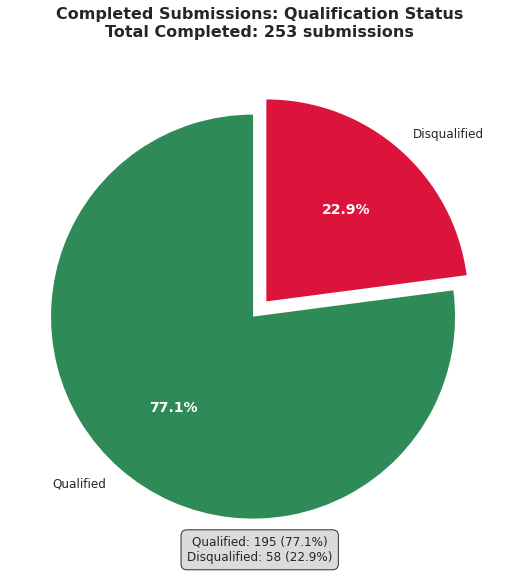


📊 Qualification Summary:
   Qualified: 195 (77.1%)
   Disqualified: 58 (22.9%)


In [29]:
# Calculate qualified vs disqualified for pie chart
total_completed = analysis_results['Total']['completed']
total_disqualified = analysis_results['Total']['disqualified']
total_qualified = total_completed - total_disqualified

if total_completed > 0:
    # Create pie chart
    fig, ax = plt.subplots(figsize=(10, 8))

    labels = ['Qualified', 'Disqualified']
    sizes = [total_qualified, total_disqualified]
    colors = ['#2E8B57', '#DC143C']  # Sea green for qualified, crimson for disqualified
    explode = (0.05, 0.05)  # Slight separation

    wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                                      startangle=90, explode=explode, textprops={'fontsize': 12})

    # Enhance the appearance
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
        autotext.set_fontsize(14)

    ax.set_title('Completed Submissions: Qualification Status\n' + 
                f'Total Completed: {total_completed:,} submissions',
                fontsize=16, fontweight='bold', pad=20)

    # Add summary text
    summary_text = f"Qualified: {total_qualified:,} ({total_qualified/total_completed*100:.1f}%)\n" + \
                   f"Disqualified: {total_disqualified:,} ({total_disqualified/total_completed*100:.1f}%)"

    plt.figtext(0.5, 0.02, summary_text, ha='center', fontsize=12, 
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Qualification Summary:")
    print(f"   Qualified: {total_qualified:,} ({total_qualified/total_completed*100:.1f}%)")
    print(f"   Disqualified: {total_disqualified:,} ({total_disqualified/total_completed*100:.1f}%)")
else:
    print("No completed submissions data available for pie chart.")

## 📊 Last Page Reached Analysis by Funnel

Frequency distribution of the furthest page reached for each funnel, showing user progression through the flow.

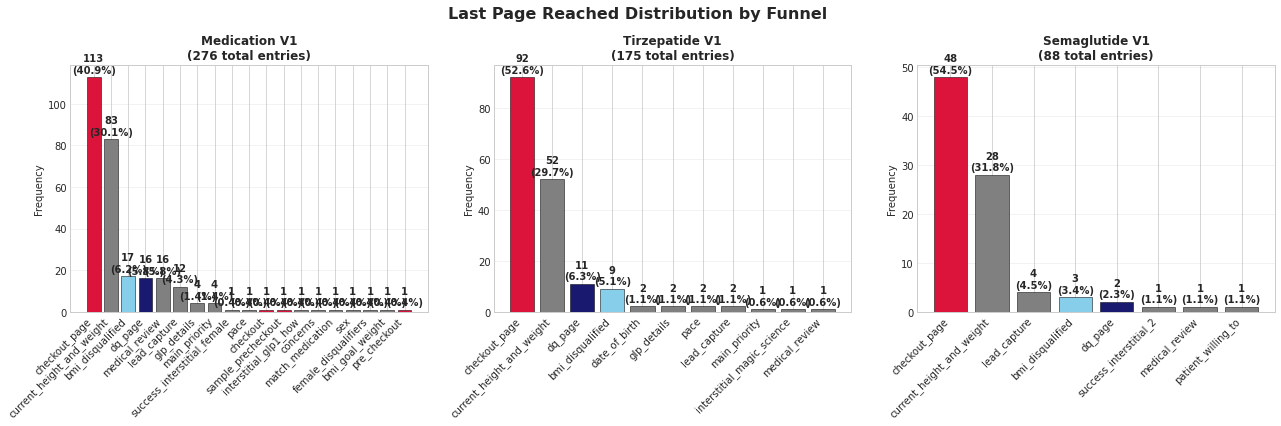


📊 DETAILED PAGE PROGRESSION ANALYSIS

MEDICATION V1:
  🔴 checkout_page: 113 (40.9%)
  ⚪ current_height_and_weight: 83 (30.1%)
  🔵 bmi_disqualified: 17 (6.2%)
  🔵 dq_page: 16 (5.8%)
  ⚪ medical_review: 16 (5.8%)
  ⚪ lead_capture: 12 (4.3%)
  ⚪ glp_details: 4 (1.4%)
  ⚪ main_priority: 4 (1.4%)
  ⚪ success_interstitial_female: 1 (0.4%)
  ⚪ pace: 1 (0.4%)
  🔴 checkout: 1 (0.4%)
  🔴 sample_precheckout: 1 (0.4%)
  ⚪ interstitial_glp1_how: 1 (0.4%)
  ⚪ concerns: 1 (0.4%)
  ⚪ match_medication: 1 (0.4%)
  ⚪ sex: 1 (0.4%)
  ⚪ female_disqualifiers: 1 (0.4%)
  ⚪ bmi_goal_weight: 1 (0.4%)
  🔴 pre_checkout: 1 (0.4%)

TIRZEPATIDE V1:
  🔴 checkout_page: 92 (52.6%)
  ⚪ current_height_and_weight: 52 (29.7%)
  🔵 dq_page: 11 (6.3%)
  🔵 bmi_disqualified: 9 (5.1%)
  ⚪ date_of_birth: 2 (1.1%)
  ⚪ glp_details: 2 (1.1%)
  ⚪ pace: 2 (1.1%)
  ⚪ lead_capture: 2 (1.1%)
  ⚪ main_priority: 1 (0.6%)
  ⚪ interstitial_magic_science: 1 (0.6%)
  ⚪ medical_review: 1 (0.6%)

SEMAGLUTIDE V1:
  🔴 checkout_page: 48 (54.5%)
 

In [30]:
def create_funnel_histograms():
    """Create histograms showing last page frequency for each funnel"""
    
    # Color mapping for specific pages
    color_map = {
        'checkout_page': '#DC143C',        # Red
        'dq_page': '#191970',              # Dark blue (midnight blue)
        'bmi_disqualified': '#87CEEB',     # Light blue (sky blue)
    }
    default_color = '#808080'  # Gray
    
    def get_color(page_name):
        """Get color for a page based on patterns"""
        page_lower = str(page_name).lower()
        if 'checkout' in page_lower:
            return color_map['checkout_page']
        elif 'dq' in page_lower and 'bmi' not in page_lower:
            return color_map['dq_page']
        elif 'bmi' in page_lower and ('disqualified' in page_lower or 'dq' in page_lower):
            return color_map['bmi_disqualified']
        else:
            return default_color
    
    # Create subplots for the three funnels
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Last Page Reached Distribution by Funnel', fontsize=16, fontweight='bold')
    
    funnel_keys = list(FUNNELS.keys())
    
    for idx, funnel_key in enumerate(funnel_keys):
        ax = axes[idx]
        
        # Use all data to show complete funnel progression
        funnel_df = funnel_data[funnel_key]['all']
        funnel_name = funnel_data[funnel_key]['name']
        
        if len(funnel_df) == 0:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14)
            ax.set_title(funnel_name, fontweight='bold')
            continue
        
        # Count page frequencies from "Furthest Page Reached"
        page_counts = funnel_df['Furthest Page Reached'].value_counts()
        total_entries = len(funnel_df)
        
        # Prepare data for plotting
        pages = page_counts.index.tolist()
        counts = page_counts.values.tolist()
        
        # Assign colors based on page names
        colors = [get_color(page) for page in pages]
        
        # Create bar chart
        bars = ax.bar(range(len(pages)), counts, color=colors, edgecolor='black', linewidth=0.5)
        
        # Add count and percentage labels on bars
        for bar, count, page in zip(bars, counts, pages):
            height = bar.get_height()
            percentage = (count / total_entries) * 100
            
            # Label above bar
            ax.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                   f'{count}\n({percentage:.1f}%)',
                   ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Customize axes
        ax.set_xticks(range(len(pages)))
        ax.set_xticklabels(pages, rotation=45, ha='right')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{funnel_name}\n({total_entries:,} total entries)', 
                    fontweight='bold')
        
        # Add grid for readability
        ax.grid(axis='y', alpha=0.3)
        ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed breakdown
    print("\n" + "="*60)
    print("📊 DETAILED PAGE PROGRESSION ANALYSIS")
    print("="*60)
    
    for funnel_key in FUNNELS.keys():
        funnel_df = funnel_data[funnel_key]['all']
        funnel_name = funnel_data[funnel_key]['name']
        
        if len(funnel_df) == 0:
            continue
            
        print(f"\n{funnel_name.upper()}:")
        page_counts = funnel_df['Furthest Page Reached'].value_counts()
        total = len(funnel_df)
        
        for page, count in page_counts.items():
            percentage = (count / total) * 100
            if 'checkout' in str(page).lower():
                status_icon = "🔴"
            elif 'dq' in str(page).lower() or 'disqualified' in str(page).lower():
                status_icon = "🔵"
            else:
                status_icon = "⚪"
            print(f"  {status_icon} {page}: {count:,} ({percentage:.1f}%)")

# Generate the histograms
create_funnel_histograms()

## 🎯 Key Insights & Recommendations

### Performance Highlights:
1. **Overall Completion Rate**: Shows how effectively we convert initiated sessions to completed submissions
2. **Funnel Performance**: Comparison across the three primary funnels
3. **Qualification Rates**: Understanding disqualification patterns
4. **Cart Conversion**: Tracking successful progression to checkout

### Data Sources:
- **Initiated**: `_all.csv` files (all submissions that started)
- **Completed**: `_complete.csv` files (submissions with DOB and Email)
- **Progression**: `Furthest Page Reached` field analysis

### Legend:
- 🔴 **Red bars**: Checkout pages (Successful completions)
- 🔵 **Blue bars**: Disqualification pages (DQ or BMI disqualified)
- ⚪ **Gray bars**: Other pages (In-progress submissions)

---

**Report Generated**: {}
**Data Source**: Embeddables/Data/ CSV files
**Analysis Period**: Current dataset snapshot".format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))